In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info

import pprint

In [29]:
boc = BrainObservatoryCache()


In [30]:
def get_datasets(boc, container_id):

    exps_container = boc.get_ophys_experiments(experiment_container_ids= [container_id], stimuli=[stim_info.NATURAL_MOVIE_ONE])
    ids = [exp['id'] for exp in exps_container]

    age_days = []
    for id in ids:
        dataset = boc.get_ophys_experiment_data(id)
        age_days.append(dataset.get_metadata()['age_days'])
    days_order = np.argsort(age_days)

    # create datasets in one container:
    datasets = []
    ordered_days = []
    for i in range(len(ids)):
        dataset = boc.get_ophys_experiment_data(ids[days_order[i]])
        ordered_days.append(dataset.get_metadata()['age_days'])
        datasets.append(dataset)

    ordered_days = np.array(ordered_days) - ordered_days[0]

    return datasets, ordered_days

In [31]:
import rep_drift

In [32]:
datasets, ordered_days = rep_drift.get_datasets(boc, 540993888)

In [33]:
cell_ids_0, dff_vals_0, run_vals_0 = rep_drift.get_response_vals(datasets[0])

In [34]:
corrs_s0, angles_s0 = rep_drift.calc_similarity(dff_vals_0)

In [35]:
import visualize_drift 

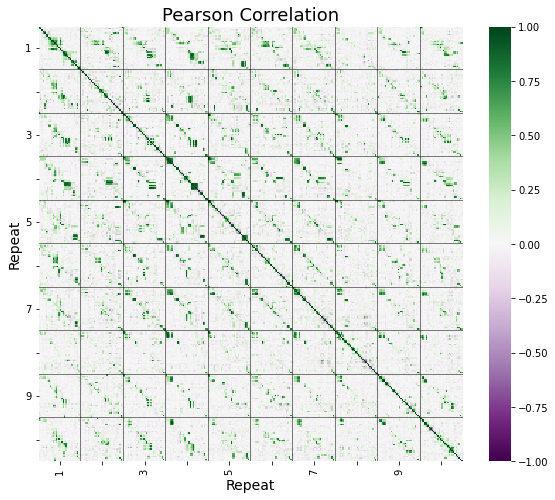

In [36]:
visualize_drift.plot_corr(corrs_s0, n_repeat_plot= 10)

In [37]:
dff_vals_container, run_vals_container = rep_drift.align_response_vals(datasets)

In [38]:
mean_vecs = rep_drift.calc_mean_vecs(dff_vals_container)

In [39]:
pcas_session, vars_session, dims_session = rep_drift.do_PCA(dff_vals_container)

In [40]:
c_vals = ['firebrick', 'darkgreen', 'blue', 'darkorange', 'm', 'deeppink', 'r', 'gray', 'g', 'navy']
c_vals_l = ['salmon', 'limegreen', 'cornflowerblue', 'bisque', 'plum', 'pink', 'tomato', 'lightgray', 'g', 'b' ]
# lol looks like before and after drift

Text(0, 0.5, 'PC2 (Group 1)')

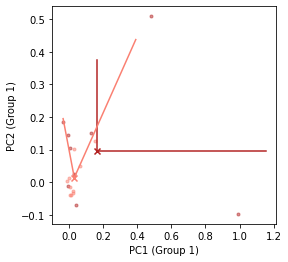

In [41]:
pc1 = 0
pc2 = 1

session_idx_early = 0
session_idx_late = 1

# pick block 0
stimuli_idx = 15

stimuli_pca_early = pcas_session[session_idx_early][stimuli_idx]

fig, ax = plt.subplots(1, 1, figsize=(4,4))

drift_pair = (session_idx_early, session_idx_late)

pca_scale = 1.5 

colors = (c_vals[0], c_vals_l[0])
for session_idx_idx, session_idx in enumerate(drift_pair):

    dff_vals_stimuli = dff_vals_container[session_idx][:, stimuli_idx, :]
    stimuli_pca = pcas_session[session_idx][stimuli_idx]

    dff_vals_pca = np.matmul(dff_vals_stimuli, stimuli_pca_early.components_.T) # yeah notic that .components returns n eigen vectors, essentionally W inverse. 

    ax.scatter(dff_vals_pca[:, pc1], dff_vals_pca[:, pc2], marker='.', 
            color=colors[session_idx_idx], alpha=0.5)
    
    stimuli_mean = np.mean(dff_vals_pca, axis=0)

    ax.scatter(stimuli_mean[pc1], stimuli_mean[pc2],
               marker='x', color=colors[session_idx_idx])
    
    pcas_proj =  np.matmul(stimuli_pca.components_, stimuli_pca_early.components_.T)

    for pc_idx in (pc1, pc2):
        pcas_proj[pc_idx] = (pca_scale * stimuli_pca.explained_variance_ratio_[pc_idx] *
                             pcas_proj[pc_idx] / np.linalg.norm(pcas_proj[pc_idx]))

        ax.plot([stimuli_mean[pc1], stimuli_mean[pc1]+pcas_proj[pc_idx, pc1]],
                [stimuli_mean[pc2], stimuli_mean[pc2]+pcas_proj[pc_idx, pc2]],
                color=colors[session_idx_idx])


ax.set_xlabel('PC1 (Group 1)')
ax.set_ylabel('PC2 (Group 1)')



In [42]:
pca1_var, pca_drift_magnitude, pca_drift_align, pca1_var_exp2_session = rep_drift.drift_geometry(dff_vals_container, pcas_session, vars_session, mean_vecs)

In [43]:
from scipy.stats import linregress

In [44]:
# average over all 30 stimuli:

vars_drift_early_flat = np.mean(pca1_var, axis = 1).flatten()

pca_drift_magnitude_flat = np.mean(pca_drift_magnitude, axis = 1).flatten()
pca_drift_align_flat = np.mean(pca_drift_align, axis = 1).flatten()

pca1_var_exp2_session_flat = np.mean(pca1_var_exp2_session, axis = 1).flatten()


In [45]:
min_var_exp = 1e-5
passed_var_idx  = vars_drift_early_flat > min_var_exp

vars_drift_early_flat_filtered = vars_drift_early_flat[passed_var_idx]

pca_drift_magnitude_flat_filtered = pca_drift_magnitude_flat[passed_var_idx]
pca_drift_align_flat_filtered = pca_drift_align_flat[passed_var_idx]

pca1_var_exp2_session_flat_filtered = pca1_var_exp2_session_flat[passed_var_idx]

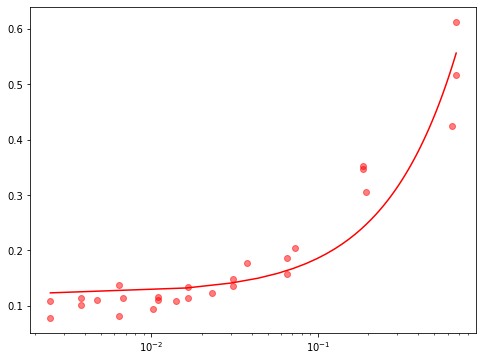

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (8,6))

x = vars_drift_early_flat_filtered
y = pca_drift_magnitude_flat_filtered

ax.scatter(x, y, c = 'r', alpha = .5)
reg = linregress(x, y)

reg_x = np.linspace(np.min(x), np.max(x), num=50)
reg_y = reg.slope * reg_x + reg.intercept
ax.plot(reg_x, reg_y, color= 'r')


ax.set_xscale('log')


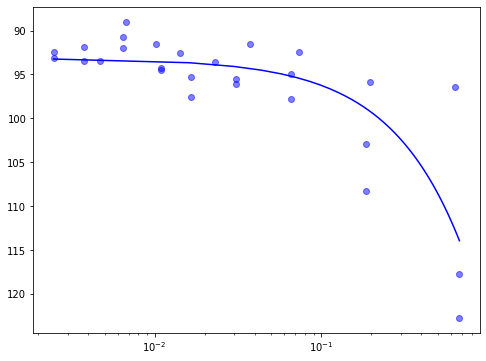

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (8,6))
x = vars_drift_early_flat_filtered
y = pca_drift_align_flat_filtered
ax.scatter(x, y, c = 'b', alpha = .5)

reg = linregress(x, y)

reg_x = np.linspace(np.min(x), np.max(x), num=50)
reg_y = reg.slope * reg_x + reg.intercept
ax.plot(reg_x, reg_y, color= 'b')


ax.set_xscale('log')
ax.invert_yaxis()

Text(0, 0.5, 'log(Var. Exp.) (later)')

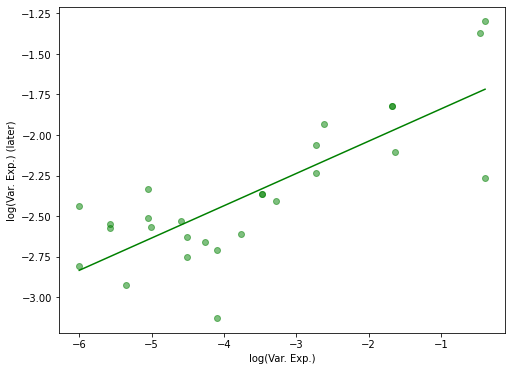

In [48]:
fig, ax = plt.subplots(1, 1, figsize = (8,6))

x = np.log(vars_drift_early_flat_filtered)
y = np.log(pca1_var_exp2_session_flat_filtered)

ax.scatter(x, y, c = 'g', alpha = .5)


reg = linregress(x, y)

reg_x = np.linspace(np.min(x), np.max(x), num=50)
reg_y = reg.slope * reg_x + reg.intercept
ax.plot(reg_x, reg_y, color= 'g')

ax.set_xlabel('log(Var. Exp.)')
ax.set_ylabel('log(Var. Exp.) (later)')

# ax.set_xscale('log')
# ax.set_yscale('log')